In [1]:
%load_ext autoreload
%autoreload 2

import jax
from jax import random
import jax.numpy as jnp
from tqdm.auto import trange, tqdm
import matplotlib.pyplot as plt

from diffbank.bank import Bank
from diffbank.metric import get_density
from diffbank.noise import Sn_aLIGO
from diffbank.utils import get_m1_m2_sampler
from diffbank.waveforms.threePN_simple import Psi, amp

Setup

In [2]:
key = random.PRNGKey(71)

minimum_match = 0.95
m_star = 1 - minimum_match
eta_target = 0.99
fs = jnp.linspace(20.0, 2000.0, 1000)
m_range = (2.5, 3.0)
sampler = get_m1_m2_sampler(m_range, m_range)

bank_r = Bank(amp, Psi, fs, Sn_aLIGO, sampler, m_star, eta_target, "3pn-random")
bank_s = Bank(amp, Psi, fs, Sn_aLIGO, sampler, m_star, eta_target, "3pn-stochastic")

theta_dmax = jnp.array([m_range[1], m_range[0]])
density_max = bank_r.density_fun(theta_dmax)
bank_r.density_max = density_max
bank_s.density_max = density_max

### Metric density

Text(0, 0.5, '$m_2$ [M$_\\odot$]')

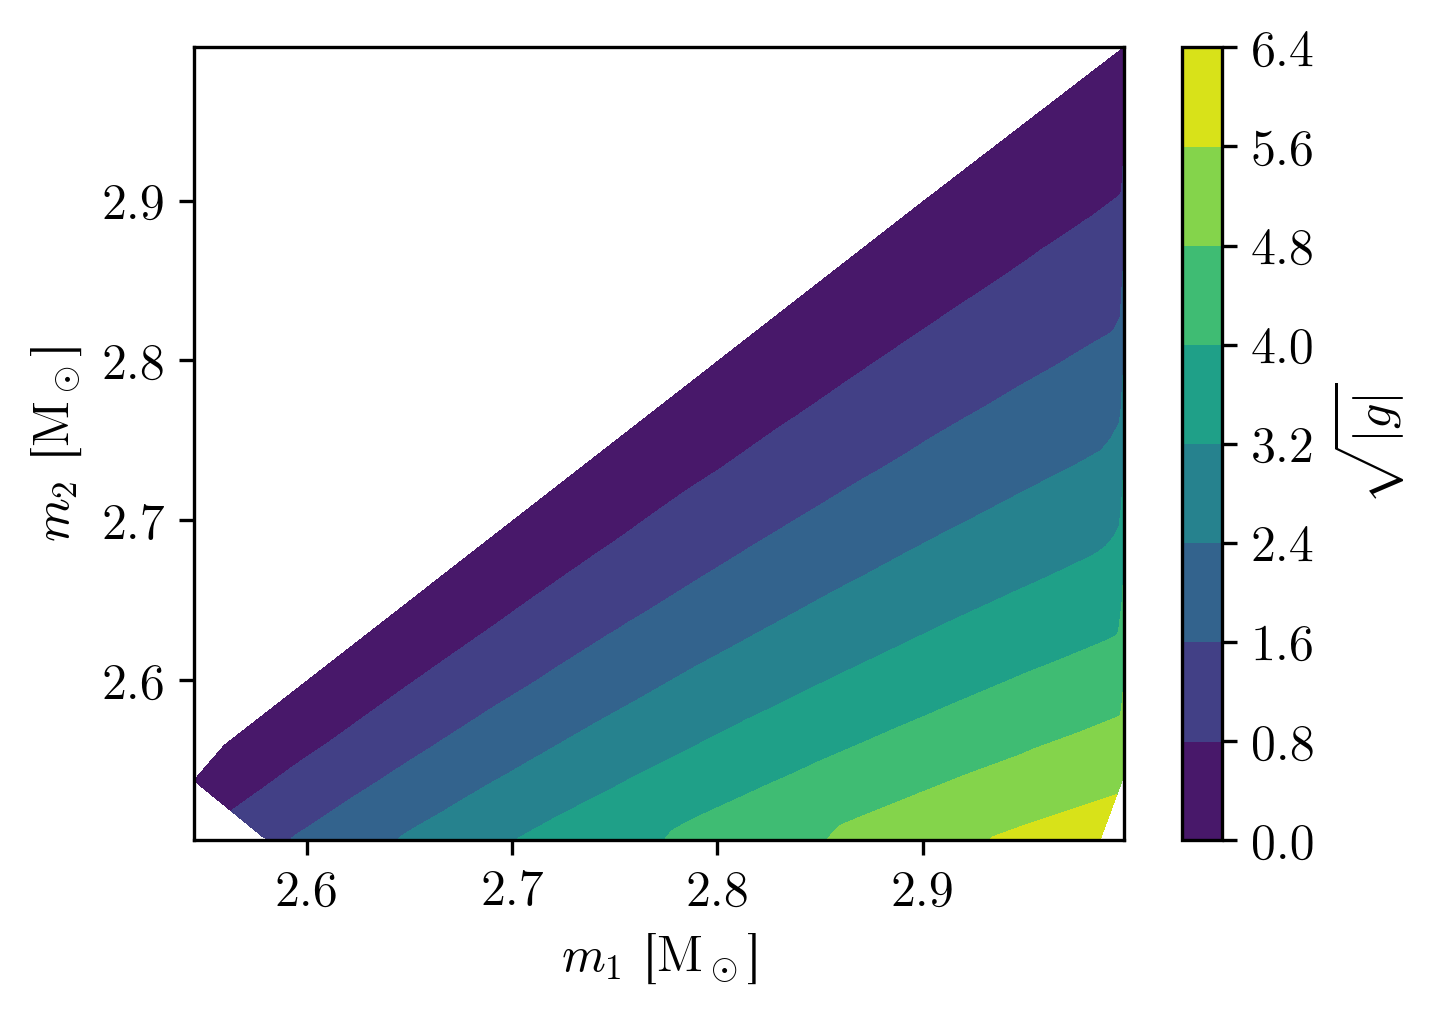

In [3]:
thetas = bank_r.sampler(key, 200)
plt.tricontourf(*thetas.T, jax.lax.map(bank_r.density_fun, thetas))
plt.colorbar(label=r"$\sqrt{|g|}$")
plt.xlabel(r"$m_1$ [M$_\odot$]")
plt.ylabel(r"$m_2$ [M$_\odot$]")

### Random bank

In [52]:
key, subkey = random.split(key)
bank_r.fill_bank(key, "random", r=0.5)

  0%|          | 0/40 [00:00<?, ?it/s]

In [53]:
key, subkey = random.split(key)
bank_r.calc_bank_effectualness(subkey, 500)

  0%|          | 0/500 [00:00<?, ?it/s]

Text(0, 0.5, '$m_2$ [M$_\\odot$]')

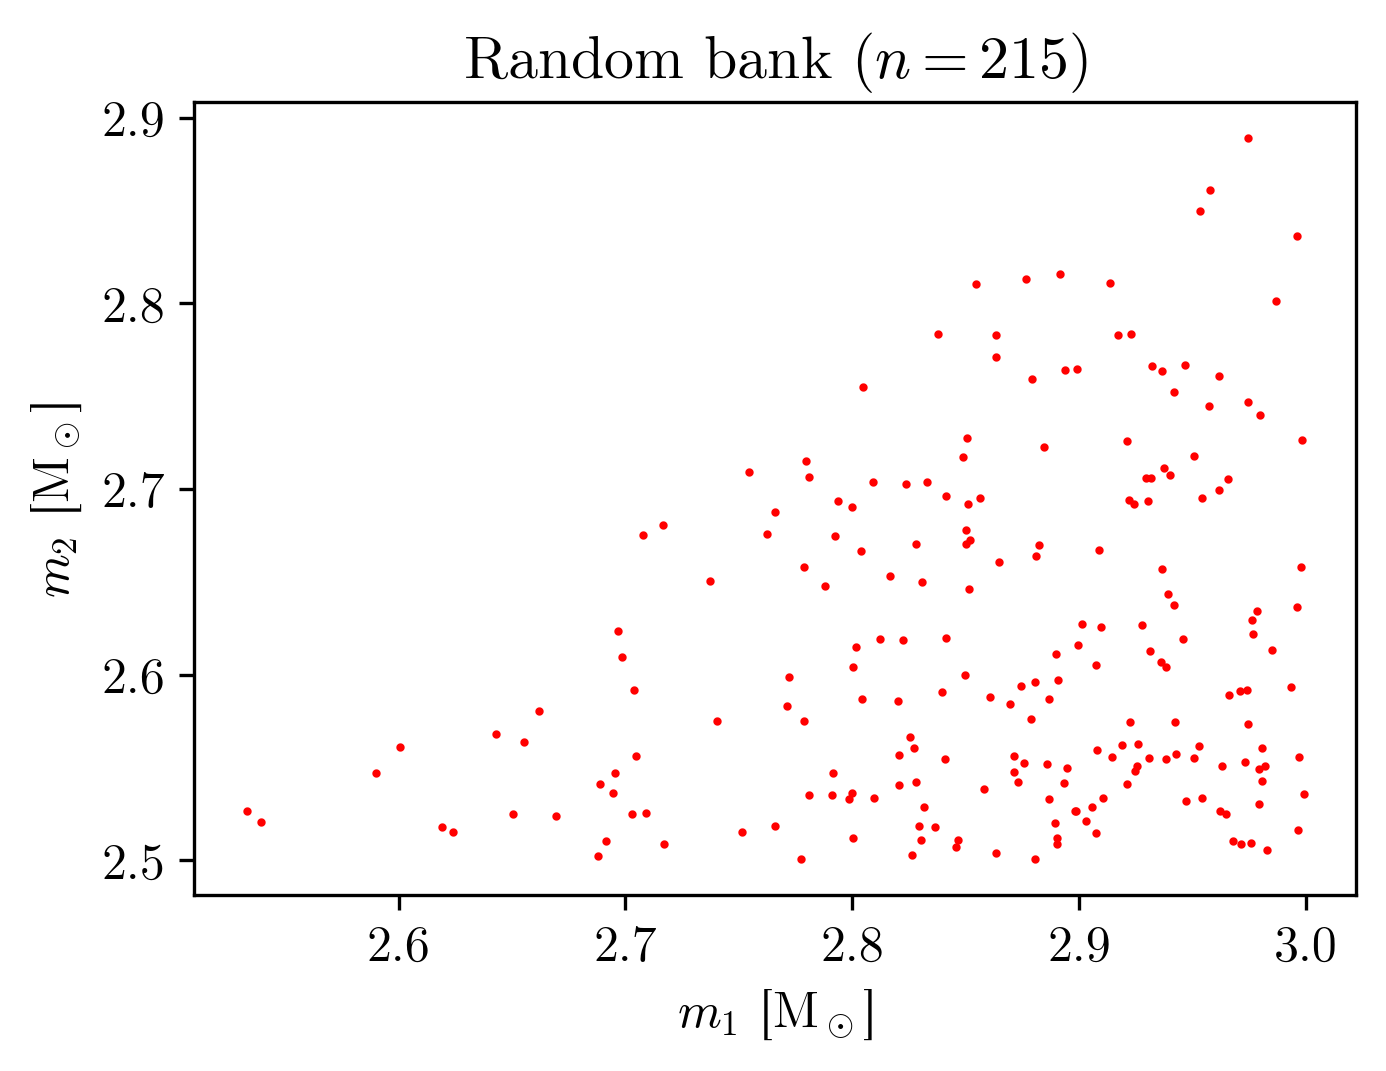

In [54]:
plt.scatter(*bank_r.templates.T, s=1, c="r")
plt.title(f"Random bank ($n = %g$)" % bank_r.n_templates)
plt.xlabel(r"$m_1$ [M$_\odot$]")
plt.ylabel(r"$m_2$ [M$_\odot$]")

### Stochastic bank

In [58]:
key, subkey = random.split(key)
bank_s.fill_bank(key, "stochastic", r=0.5)

  0%|          | 0/40 [00:00<?, ?it/s]

In [59]:
key, subkey = random.split(key)
bank_s.calc_bank_effectualness(subkey, 500)

  0%|          | 0/500 [00:00<?, ?it/s]

Text(0, 0.5, '$m_2$ [M$_\\odot$]')

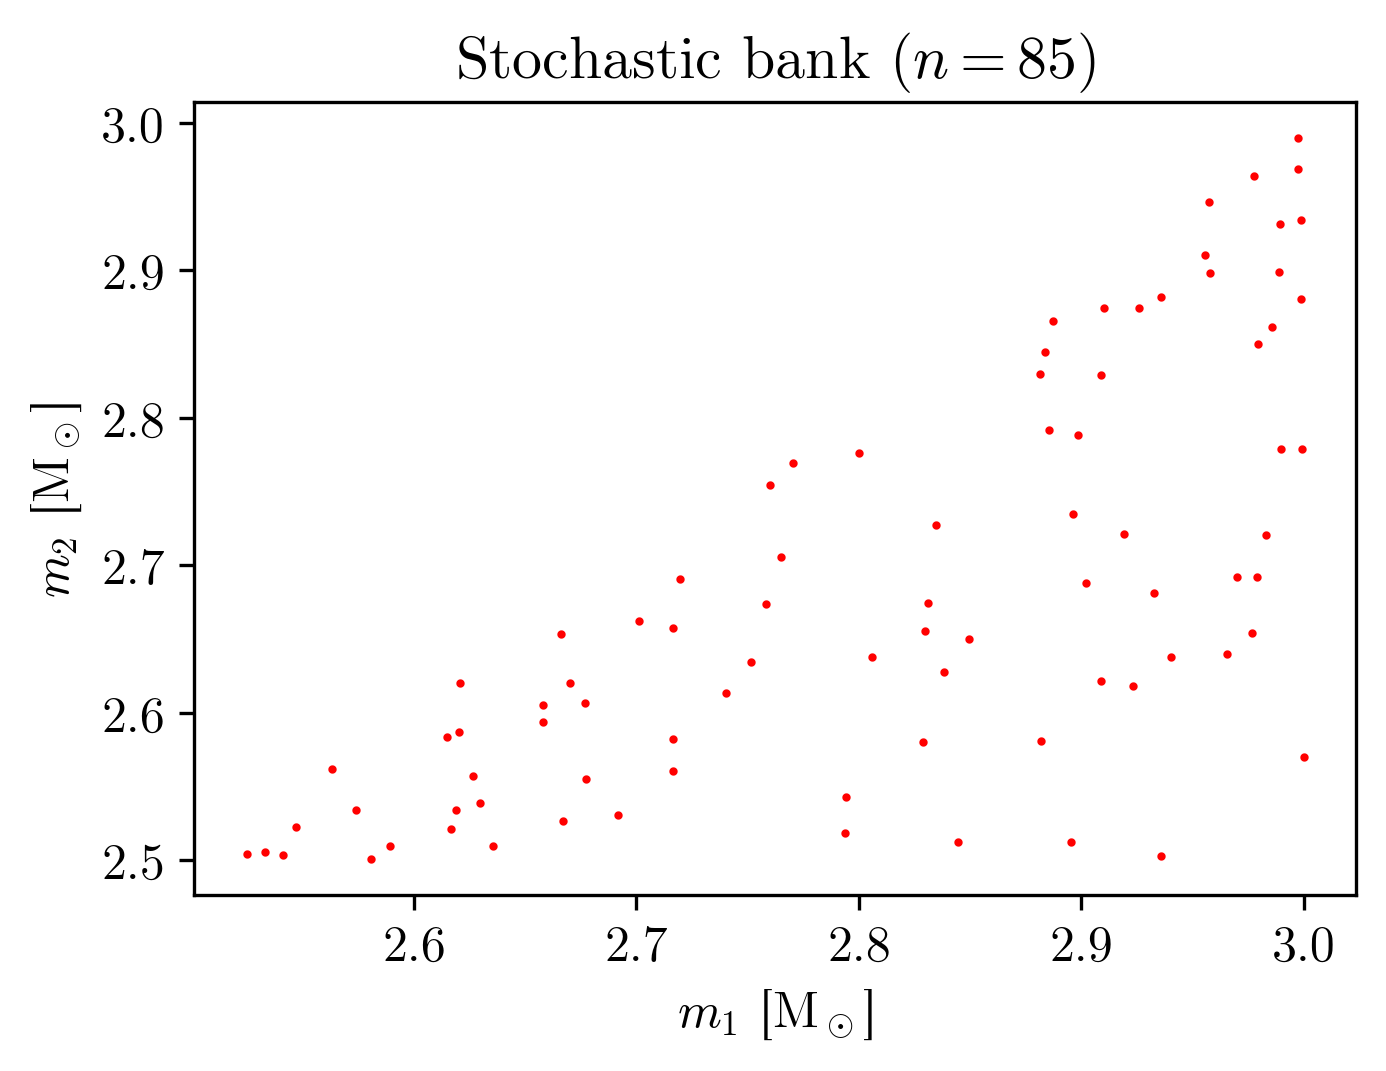

In [60]:
plt.scatter(*bank_s.templates.T, s=1, c="r")
plt.title(f"Stochastic bank ($n = %g$)" % bank_s.n_templates)
plt.xlabel(r"$m_1$ [M$_\odot$]")
plt.ylabel(r"$m_2$ [M$_\odot$]")

### Comparison

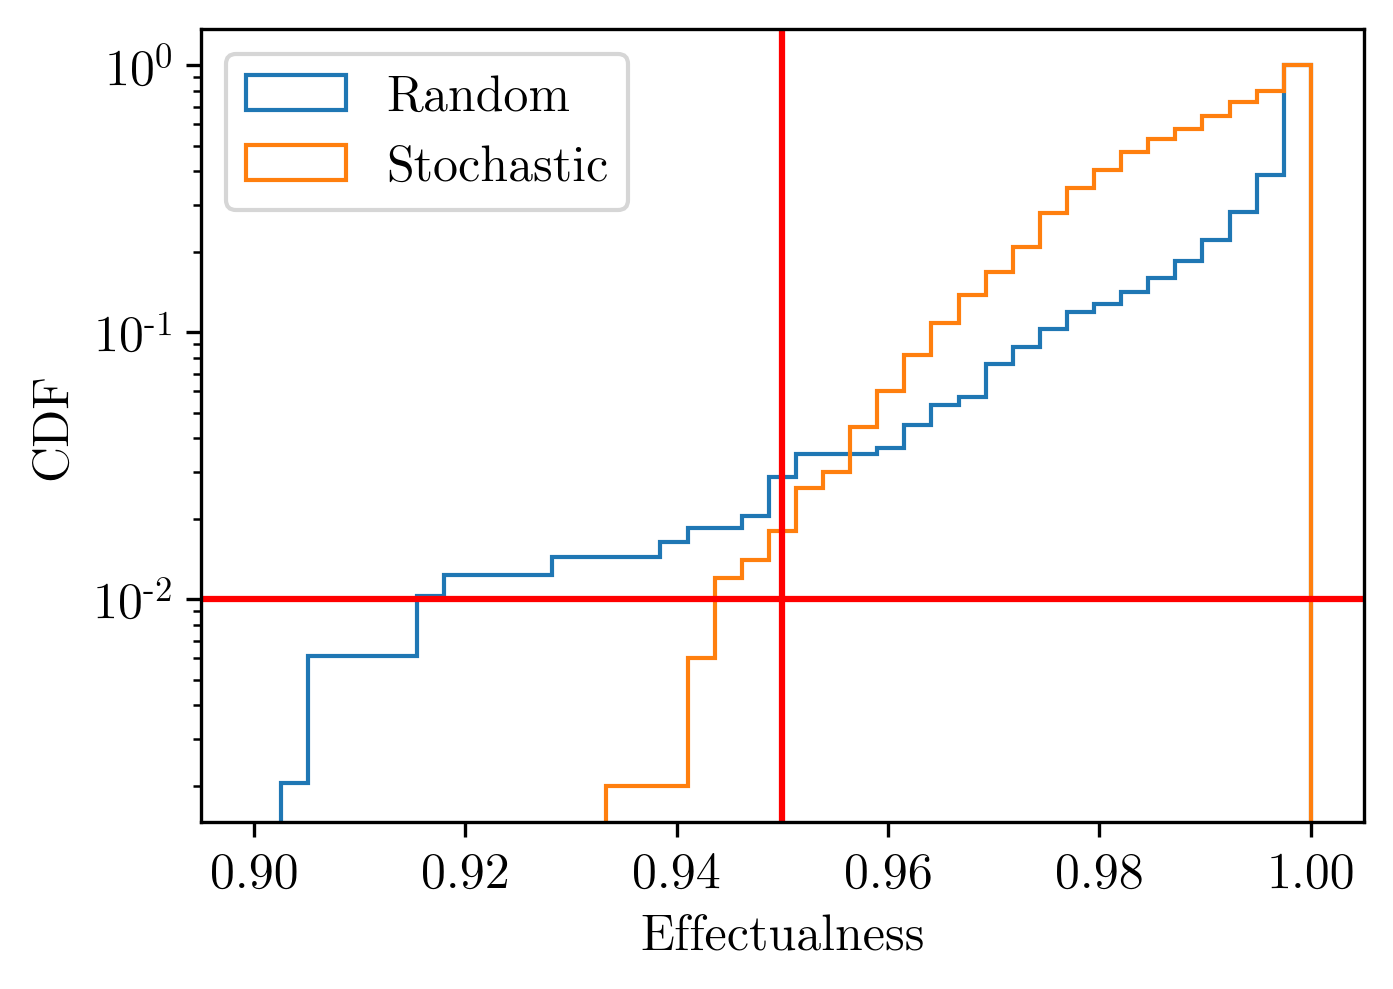

In [61]:
bins = jnp.linspace(0.9, 1.0, 40)
plt.hist(
    bank_r.effectualnesses,
    histtype="step",
    bins=bins,
    cumulative=True,
    density=True,
    label="Random",
)
plt.hist(
    bank_s.effectualnesses,
    histtype="step",
    bins=bins,
    cumulative=True,
    density=True,
    label="Stochastic",
)
plt.axvline(minimum_match, color="r")
plt.axhline(1 - eta_target, color="r")
plt.legend(loc="upper left")
plt.xlabel("Effectualness")
plt.ylabel("CDF")
plt.yscale("log")